Due to the failure of the last comedy special from SussexBudgetProductions at the box office, we have been tasked with finding the root cause of this issue. 

This is an analysis on the IMDB movie data in order to obtain insights on how the next set of funds can be properly invested. This report explores previous data using the IMDB dataset and also recommends actionable plans.

The dataset provided contains metrics relating to each movie such as : 

Color, director_name, Number of reviews, Duration, director's facebook likes,actor's facebook likes, actor's name, actor facebook likes, gross, genres, movie title,number of voted users, cast's total facebook likes,facenumber in poster,keywords in the plot,imdb link of the movie, Number of user reviews, language, country, content rating, budget, year movie was released. imdb score,the aspect ratio, movie facebook likes.

The dataset was wrangled and modified to include indicators with which we can project fututre sales: 

- Metrics retained include the director's name, genres, country ,movie title, names of the top three actors in the movie, year of the movie, content_rating, imdb_score, movie_facebook_likes, budget, gross, number of critic reviews, duration,keywords plot, language of the movie. The key metric being analysed is the gross sales,and the relationships with other metrics. 

- Metrics such as the aspect ratio of a movie are discarded as they are deemed to have minimal relationship to gross sales. 

- Duration of the movie is also not considered as we are ignoring the role the attention span of a viewer plays on the sales. 

To begin, I will split the dataset into two. One as an experimental dataset where we explore relationships between the metrics listed above, while the other to test discovered hypothesis. Confirming/rejecting our hypothesis will help make reasonable and actionable recommendations.

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from nltk.probability import FreqDist
import scipy.stats

sns.set_style("whitegrid")

In [6]:
movie_data = "movie_metadata.csv"

movie_data_df = pd.read_csv(movie_data)
movie_data_df = movie_data_df.sample(frac =1.0, random_state= 42) 
midpoint = len(movie_data_df)//2


dev_list = movie_data_df[:midpoint]  
test_list = movie_data_df[midpoint:]   

dev_list.columns
print("Columns in the dataframe are {} and the length of dev-list is {}".format(dev_list.columns, len(dev_list)))

Columns in the dataframe are Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object') and the length of dev-list is 2521


In [4]:
#Selecting Columns of interest 

modified_dev_list = dev_list[['director_name','plot_keywords', 'genres','country','movie_title', 'actor_2_name','title_year', 'actor_3_name', 'content_rating','imdb_score', 'movie_facebook_likes','budget', 'gross','num_critic_for_reviews', 'duration', 'language']]
modified_dev_list.sort_values( by = 'gross', ascending= True)

modified_dev_list

,director_name,plot_keywords,genres,country,movie_title,actor_2_name,title_year,actor_3_name,content_rating,imdb_score,movie_facebook_likes,budget,gross,num_critic_for_reviews,duration,language
4943,Sai Varadan,place name in title,Drama,USA,An American in Hollywood,Hassan Johnson,2014.0,Samantha Esteban,R,7.2,72,125000.0,NaN,3.0,89.0,English
1919,Craig Gillespie,baseball|based on true story|india|sports agen...,Biography|Drama|Sport,USA,Million Dollar Arm,Suraj Sharma,2014.0,Gregory Alan Williams,PG,7.0,10000,25000000.0,36447959.0,151.0,124.0,English
1049,James Mangold,bridge|brooklyn bridge|falling down an elevato...,Comedy|Fantasy|Romance,USA,Kate & Leopold,Natasha Lyonne,2001.0,Bradley Whitford,PG-13,6.4,0,48000000.0,47095453.0,125.0,123.0,English
4697,Jennifer Wynne Farmer,cosmetics|female protagonist|native american|n...,Drama,USA,Naturally Native,Akima,1998.0,Max Gail,PG-13,6.5,102,700000.0,10508.0,2.0,107.0,English
3312,Dario Argento,black cat|cat|evil|photographer|undead,Horror,Italy,Two Evil Eyes,Adrienne Barbeau,1990.0,Sally Kirkland,R,6.1,375,9000000.0,349618.0,76.0,120.0,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3437,David Oelhoffen,algerian war|based on short story|hostage|teac...,Drama|War|Western,France,Far from Men,Reda Kateb,2014.0,Ángela Molina,NaN,7.3,2000,7700000.0,NaN,102.0,101.0,French
3718,Kevin Smith,fast food|fast food restaurant|new jersey|quic...,Comedy,USA,Clerks II,Jason Mewes,2006.0,Brian O'Halloran,R,7.4,0,5000000.0,24138847.0,174.0,97.0,English
3346,J.C. Chandor,boat|container|sea|shipping container|storm,Action|Adventure|Drama,USA,All Is Lost,NaN,2013.0,NaN,PG-13,6.9,18000,9000000.0,6262942.0,346.0,106.0,English
4867,Michael Kang,absent father|asian american|friendship betwee...,Comedy|Drama,USA,The Motel,Clint Jordan,2005.0,Jackie Nova,NaN,6.8,62,NaN,47111.0,27.0,75.0,Cantonese


Visualizing Plot keywords given a query. The reason behind this is that keywords can sometimes be what informs a viewer's choice of a movie to watch.

In [80]:
def display_text_stat(query :str):
    r"""Displays the counts of words used in plot of different subframes, simple enter query you wish
    to access. Query is processed with pandas"""

    df = modified_dev_list.query(query,  engine='python')

    df = df[['plot_keywords']]
    df['plot_keywords'] = df['plot_keywords'].astype(str).map(lambda x: x.split('|'))

    keywords_list = []
    for item in df['plot_keywords'].tolist():
        keywords_list = keywords_list + item

    distrib = dict(FreqDist(keywords_list))
    distrib = pd.DataFrame(distrib, index = range(len(distrib.keys())))
    distrib = distrib.T.reset_index()[['index', 0]].sort_values(by = 0, ascending = False)
    distrib.columns = ['words', 'count']

    fig = px.treemap(distrib[0:100], path=[px.Constant("Plot keywords"), 'words'],
                    values='count',
                    color='count',
                    color_continuous_scale='viridis',
                    color_continuous_midpoint=np.average(distrib['count'])
                    )
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    return fig.show()
    

In [81]:
display_text_stat('genres.str.contains("Drama") and genres.str.contains("Comedy")')

In [87]:
display_text_stat('content_rating == "PG-13"')

EXAMINATION OF GROSS SALES : 

The gross sales is the key metric with which performance of the next movie will be judged. The examination of previous sales of movies will assist in making a projected outcome.

Text(0.5, 1.0, 'Box plot of gross sales')

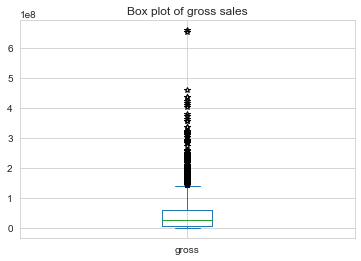

In [4]:
modified_dev_list['gross'].plot(kind = 'box', sym = '*', whis = 1.5)
plt.title("Box plot of gross sales")

From the above chart,  it can be seen above, the chart of the gross plot is extremely positively skewed with a lot of outliers. This means the gross sales of movie datasets is not normally distributed and using central tendency measures such as mean,mode and median to obtain a cutoff threshold may be misleading.

Gross sales vs Content rating 

Text(0, 0.5, 'count')

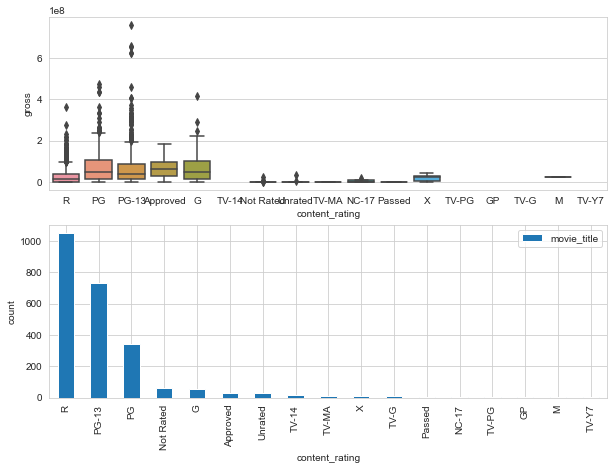

In [97]:
#Checking the relationship between the content rating and gross 
fig, ax = plt.subplots(2,1, figsize = (10,7))
ax1 = sns.boxplot(y = modified_dev_list['gross'].dropna(), x = modified_dev_list['content_rating'].dropna(), ax = ax[0])
plt.xticks(rotation = 90 )
#plt.title("Gross sales vs Content_rating")

content_rating_df = modified_dev_list[['movie_title','content_rating']].dropna()
count_content_rating_df = content_rating_df.groupby('content_rating').count().sort_values(by = 'movie_title', ascending = False)
count_content_rating_df.plot(kind = 'bar', ax= ax[1])

plt.ylabel('count')
#plt.title('Number of movies in each rating')

In [104]:
display_text_stat('content_rating == "G"')


It can be seen that the categories "R","PG-13","PG" account for a major proportion of movies produced.

It can be seen in the box plot that :
- gross sales beating projection, with a lot of outlier values is a prevalent thing in the 'R', 'PG-13', and 'PG' group.
- the 'G' content rating category that the mean of gross sales surpasses other categories, although with less outliers.
- there are no outliers in the "Approved" category, which also presents a safe option.

A point worthy of note is the low count of movies in the "G" category and the high average gross sale within this category. This suggests that an average movie in the "G" category makes a certain number of sales. This option seems a safe,low-risk option.


GROSS SALES VS COUNTRY OF PRODUCTION

Text(0.5, 1.0, 'gross sales vs country')

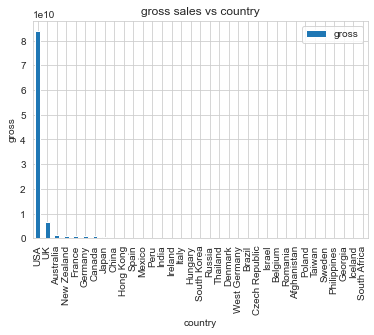

In [7]:
#Checking the amount of movies in the content_rating categories
gross_df = modified_dev_list[['country','gross']].dropna()
gross_df = gross_df.groupby('country').sum().sort_values(by = 'gross', ascending = False)
gross_df.plot(kind = 'bar')
plt.ylabel('gross')
plt.title("gross sales vs country")

Above is a chart that shows the gross sales, by country of production. It shows that majority of the movies are produced in the United States of America, followed by United Kingdom. It does not provide more information on which countries are responsible for the gross sale of this products

Budget Breakdown

In [105]:
modified_dev_list['budget'].describe()

count    2.278000e+03
mean     4.379772e+07
std      2.796587e+08
min      1.100000e+03
25%      6.000000e+06
50%      2.000000e+07
75%      4.500000e+07
max      1.221550e+10
Name: budget, dtype: float64

Above is a breakdown of the budget statistics. It shows a maximum budget of around 12 billion, a minimum of 1100 and a mean of 44 million. 

Text(0.5, 1.0, 'Plot of Gross vs Budget')

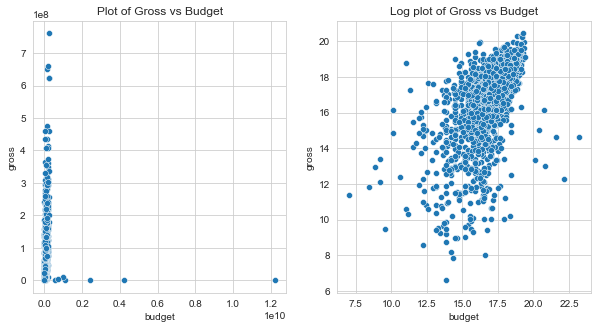

In [114]:
#Check relationship between gross and budget of movies
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.scatterplot(x = np.log(modified_dev_list['budget']), y = np.log(modified_dev_list['gross']), ax = ax[1])
ax[1].set_title("Log plot of Gross vs Budget")

sns.scatterplot(x = modified_dev_list['budget'], y = modified_dev_list['gross'], ax = ax[0])
ax[0].set_title("Plot of Gross vs Budget")

In [108]:
modified_dev_list = modified_dev_list.dropna()
pearson_corr, _ = scipy.stats.pearsonr(modified_dev_list['gross'], modified_dev_list['budget'])
spearman_corr, _ = scipy.stats.spearmanr(modified_dev_list['gross'], modified_dev_list['budget'])

print("The pearson correlation between gross and budget is {} while the spearman correlation is {}".format(pearson_corr, spearman_corr))

The pearson correlation between gross and budget is 0.06424386347185942 while the spearman correlation is 0.6302213956994931


The correlation above displays that although there is a correlation between the budget of a movie and the sales, it is not linear but monotoic as displayed by spearman

In [11]:
import numpy as np
#Using the top 75 percentile of the dev_test to determine characteristics of our next movie,  by examining the top 75, we can assess the predominant features

imdb_score = modified_dev_list['imdb_score']
gross = modified_dev_list['gross'].dropna()

imdb_75 = np.percentile(list(imdb_score), 75)
gross_75 = np.percentile(list(gross), 75)
gross_25 = np.percentile(list(gross), 25)

summary_statistics = list(gross.describe())

#Format output to be easily readable
print (f"Here are the statistics of the gross sales in the development dataset :  \nCount is {summary_statistics[0]}, \nMean is {summary_statistics[1]}, \nstandard_deviation value is {summary_statistics[2]}, \nMinimum is {summary_statistics[3]}, \n25th percentile is {summary_statistics[4]}, \n50th percentile is {summary_statistics[5]}, and \n75th percentile is {summary_statistics[6]}, \nMaximum value is {summary_statistics[7]}")

Here are the statistics of the gross sales in the development dataset :  
Count is 2061.0, 
Mean is 47022531.91508976, 
standard_deviation value is 64899281.77086928, 
Minimum is 1111.0, 
25th percentile is 5773519.0, 
50th percentile is 26003149.0, and 
75th percentile is 60054449.0, 
Maximum value is 658672302.0


In the same way, we make a statistical analysis of the gross, to know the average gross sales per movie, the 25th percentile, the 75th percentile. This will enable us make a reasonable projection for our next movie at SussexBudgetProductions. 

Relationships between gross sales and Underlying factors can be seen below. 

<AxesSubplot:xlabel='title_year'>

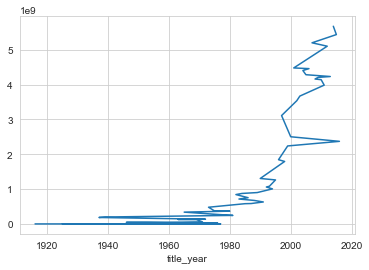

In [12]:
#Trend line to show gross over the years
modified_dev_list.groupby('title_year')['gross'].sum().sort_values(ascending = False).plot(kind = 'line')

1st chart above shows the relationship between the title_year and gross sales. It can be seen to group exponential over a period of 20 years up until 2000, where it has staggered back and forth. This can be attributed to less friction between the viewer and TV show with the advent of online streams and other experience shaping platforms. Since we cannot rewind time, it is inconsequential

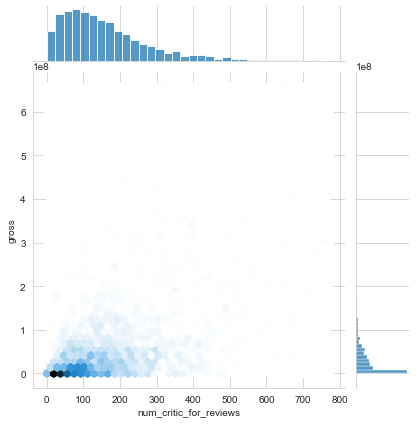

In [13]:
#Check relationship between gross and number of critic reviews

ax1 = sns.jointplot(x = modified_dev_list['num_critic_for_reviews'], y = modified_dev_list['gross'], kind = "hex")

/opt/homebrew/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning:

divide by zero encountered in log



Text(0.5, 1.0, 'Gross vs movie_facebook_likes')

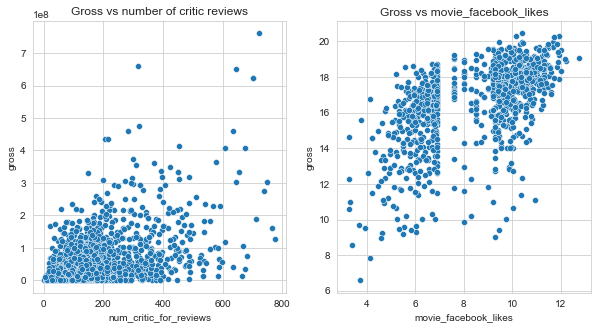

In [119]:
#Check relationship between gross and number of critic reviews
fig,ax = plt.subplots(1,2, figsize = (10,5))
ax1 = sns.scatterplot(x = modified_dev_list['num_critic_for_reviews'], y = modified_dev_list['gross'], ax = ax[0])
ax[0].set_title("Gross vs number of critic reviews")

ax1 = sns.scatterplot(x = np.log(modified_dev_list['movie_facebook_likes']), y = np.log(modified_dev_list['gross']), ax = ax[1])
ax[1].set_title("Gross vs movie_facebook_likes")

Imdb score vs gross sales 

Text(0, 0.5, 'gross_sales')

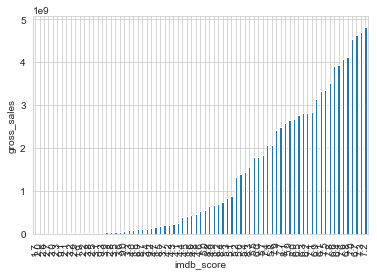

In [15]:
modified_dev_list.groupby('imdb_score')['gross'].sum().sort_values(ascending = True).plot(kind = 'bar')
plt.ylabel("gross_sales")

We can see from the above plot that the gross sale of a movie increases with the IMDB SCORE. This is good, as it's a 

Examining Imdb_score

<AxesSubplot:>

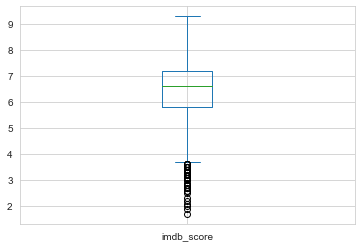

In [17]:
modified_dev_list['imdb_score'].plot(kind = 'box')

Text(0, 0.5, 'count')

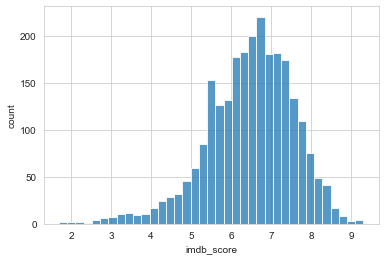

In [18]:
sns.histplot(modified_dev_list['imdb_score'])
plt.ylabel("count")

In [19]:
modified_dev_list['imdb_score'].describe()

count    2521.000000
mean        6.469695
std         1.090097
min         1.700000
25%         5.800000
50%         6.600000
75%         7.200000
max         9.300000
Name: imdb_score, dtype: float64

The boxplot is negatively skewed, we can use the value of the mean as a reasonable threshold as this covers a significant segment of the data.

Examining the box plot of the modified list, we can use the mean value to arrive at a reasonable threshold to filter suitable actors, directors, and genres for the production of our next movie. 

We exclude directors and movies with a score lower than the MEAN which is approximately 6.5

In [20]:
#filtere dev_list to imdb_score greater than 6.5
imdb_above_6_5 = modified_dev_list[modified_dev_list['imdb_score'] > 6.5]
imdb_score = imdb_above_6_5[['director_name','actor_2_name','actor_3_name','imdb_score','genres', 'gross', 'movie_title']]

#imdb_score.sort_values('count')
director_movies =imdb_score.loc[:,['director_name','movie_title']].groupby('director_name')

#make a new dataframe indexed by director which stores director and counts of movie titles
movie_counts=director_movies.count().reset_index('director_name')

#change column name to reduce confusion
movie_counts.columns = ['director_name','number of movies']

#sort by appropriate column
movie_counts = movie_counts.sort_values('number of movies', ascending=False)

#put into object containing the top director by name
movie_x_dir = movie_counts[0:10]['director_name']

#take a look at the top of the sorted object with name and number of movies 
movie_counts[0:10]

,director_name,number of movies
475,Martin Scorsese,11
802,Woody Allen,11
734,Steven Spielberg,9
595,Peter Jackson,8
641,Ridley Scott,8
116,Clint Eastwood,7
733,Steven Soderbergh,7
681,Sam Mendes,6
723,Stephen Frears,6
661,Robert Zemeckis,6


The above list shows the list of recommended directors for the next movie. These are directors with a number of movies with an IMDB score greater than 6.5

In [27]:
#Examining the predominant genres in top grossing movies
top_grossing = imdb_above_6_5.sort_values(by = 'gross', ascending = False)

#Converts Pd.series to list
rec_genres = list(top_grossing['genres'])
new_rec_genres = []

#Splits element into individual genre
for element in rec_genres:
    new = element.split('|')
    new_rec_genres += new 
new_rec_genres

#Computes frequency of genres from list
from nltk.probability import FreqDist

genre_distribution = FreqDist(new_rec_genres)
genre_series = pd.Series(genre_distribution)

genre_df = genre_series.to_frame().reset_index()
genre_df.columns = ['Genre', 'Count']

#Sort and view values 
genre_df.sort_values(by= ["Count"], ascending= False)

,Genre,Count
0,Drama,843
7,Comedy,371
5,Thriller,316
1,Romance,278
3,Adventure,247
2,Action,243
13,Crime,243
4,Sci-Fi,154
9,Fantasy,142
10,Mystery,142


## Hypothesis

To verify our hypothesis about the correlation between the budget of a movie and the gross value of sales, we perform a correlation test  on the test data using the pearson's and spearman's correlation test. Using a significance level of 5%, corresponding to a p-value of 0.05 as a standard. The p-value/significance level is the percentage that the occurence in your sample is by chance, thus a significance level of 5% shows that 5% of the happenings in our sample is by chance.

Null Hypothesis,H0 : There is no correlation between the gross sales and budget.

If p_value(test data) is less than 0.05. We fail to reject the null hypothesis. there's no correlation between the gross sales of a movie and the budget.

Alternative Hypothesis, H1 :If p_value(test data) is greater than 0.05 We reject our null hypothesis, thus accepting there's a correlation between the gross sales of a movie and the budget.

From above, the predominant genres in the top grossing movies are shown above. It can be seen that Drama occured the most - 820 times, followed by Comedy which occured 377 times. Genres such as Thriller,Romance,Adventure,Action,Crime all have close numbers. 

Since the aim is to increase our chances of a top grossing movie, I'd advice a combination of the top grossing genres Drama and Comedy in addition to one of the rest,Adventure,Thriller,Drama, Comedy,Family,Fantasy, Family

Hypotheses that been have designed relating to the overall aim of this analysis

The third trend noticed in our dev set is that movies in the PG-13 content rating category record the highest average sales per movie. By confirming this hypothesis, we can make
an informed decision on the category to aim our next movie at, this can help inform ideas on movie plots.

To confirm this hypothesis, we perform a T-test on the test_data. Comparing the PG-13 content rating category with other categories.

## Recommendations

Actionable recommendations based on the analyses you have conducted.

Based on our analysis above, it can be seen that the performance the next movie doesn't entirely depend on how large our budget is. With a limited budget of 1.5million, we can optimize the spending of this budget by closely examining the genres,directors and actors involved.

- Genres such as Action, Adventure, Fantasy, Sci-Fi have been seen to amass a lot of sales. A mixture of genres can be appealing to wider segments resulting in more sales. Regarding the country of production, movies from the USA have also been seen to amass a lot of sales.

- The presence of directors such as 
Martin Scorses, 
Steven Spielberg, 
Woody Allen, 
Ridley Scott	
Peter Jackson	
Steven Soderbergh
Ron Howard	
Yimou Zhang	
Spike Lee	
Stephen Frears	 have been associated with higher sales of the movie.

- Since a high percentage of sales grouped by content rating comes from the PG-13, PG,R and G. It is advised that the content rating of our next movie should be within these categories to increase the probabilities reaching our gross projections.